In [213]:
from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import pandas as pd
import numpy as np

In [2]:
acct = pd.read_parquet('dsc180-fa23/q2_acctDF_final.pqt')
cons = pd.read_parquet('dsc180-fa23/q2_consDF_final.pqt')
inflows = pd.read_parquet('dsc180-fa23/q2_inflows_final.pqt')
outflows = pd.concat([
    pd.read_parquet('dsc180-fa23/q2_outflows_1sthalf_final.pqt'),
    pd.read_parquet('dsc180-fa23/q2_outflows_2ndhalf_final.pqt')
])
outflows['amount'] = -outflows['amount']
total = pd.concat([inflows, outflows])

In [3]:
outflows[outflows['prism_consumer_id'] == 0].sort_values(by='posted_date')

,prism_consumer_id,prism_account_id,memo_clean,amount,posted_date,category_description
420,0,acc_1,CASH APP*FREE XXXXXXXXXX CA 04/15,-150.00,2022-04-15,GENERAL_MERCHANDISE
281,0,acc_1,Payment to Chase card ending in XXXX 04/15,-100.00,2022-04-15,CREDIT_CARD_PAYMENT
735,0,acc_1,CASH APP*FREE XXXXXXXXXX CA 04/14,-60.00,2022-04-15,GENERAL_MERCHANDISE
591,0,acc_1,EMC SECURITY GA 04/16,-35.00,2022-04-18,GENERAL_MERCHANDISE
273,0,acc_1,TIAA-CREF LOAN LOAN REPAY PPD ID: XXXXXXXXXX,-41.39,2022-04-18,LOAN
...,...,...,...,...,...,...
255,0,acc_1,Online Transfer to SAV ...XXXX transaction#: X...,-300.00,2023-04-11,SELF_TRANSFER
902,0,acc_1,CASH APP*ADRIENNE XXXXXXXXXX CA 04/10,-200.00,2023-04-11,GENERAL_MERCHANDISE
557,0,acc_1,Amazon.com*HS08O2IE2 Amzn.com/bill WA 04/10,-46.00,2023-04-11,GENERAL_MERCHANDISE
200,0,acc_1,TRANSFER TO SAV XXXXXXXXX 04/12,-25.00,2023-04-12,SELF_TRANSFER


In [26]:
def get_month(d):
        return d.strftime("%Y-%m")

total['datetime'] = pd.to_datetime(total['posted_date'])
total['month'] = total['datetime'].apply(get_month)
consumer_intervals = total[['prism_consumer_id', 'month']].groupby('prism_consumer_id').agg(['min', 'max'])

In [27]:
consumer_intervals

month         
                       min      max
prism_consumer_id                  
0                  2022-04  2023-04
2                  2021-12  2022-02
4                  2020-08  2021-08
7                  2020-08  2021-08
9                  2022-04  2023-04
...                    ...      ...
5941               2022-03  2023-01
5943               2022-07  2023-02
5944               2023-01  2023-02
5945               2021-02  2023-02
5949               2021-09  2023-01

[2978 rows x 2 columns]

In [28]:
consumer_intervals.columns = ['min', 'max']

In [29]:
consumer_intervals

,min,max
prism_consumer_id,,
0,2022-04,2023-04
2,2021-12,2022-02
4,2020-08,2021-08
7,2020-08,2021-08
9,2022-04,2023-04
...,...,...
5941,2022-03,2023-01
5943,2022-07,2023-02
5944,2023-01,2023-02


In [30]:
consumer_intervals = consumer_intervals.to_dict()

In [31]:
total

,prism_consumer_id,prism_account_id,memo_clean,amount,posted_date,category_description,datetime,month
0,0,acc_0,TRANSFER FROM CHK XXXXXXXXX,25.00,2022-05-04,SELF_TRANSFER,2022-05-04,2022-05
1,0,acc_0,TRANSFER FROM CHK XXXXXXXXX,25.00,2023-01-18,SELF_TRANSFER,2023-01-18,2023-01
2,0,acc_0,TRANSFER FROM CHK XXXXXXXXX,25.00,2023-03-01,SELF_TRANSFER,2023-03-01,2023-03
3,0,acc_0,INTEREST PAYMENT,0.05,2023-02-28,INVESTMENT_INCOME,2023-02-28,2023-02
4,0,acc_0,INTEREST PAYMENT,0.07,2023-01-31,INVESTMENT_INCOME,2023-01-31,2023-01
...,...,...,...,...,...,...,...,...
3084767,3997,acc_7534,Cenex F U Oil,-16.93,2023-06-07,AUTOMOTIVE,2023-06-07,2023-06
3084768,3997,acc_7534,Cenex F U Oil,-20.72,2023-06-14,AUTOMOTIVE,2023-06-14,2023-06
3084769,3997,acc_7534,Reserveit Park/Shower,-25.00,2023-04-08,HOME_IMPROVEMENT,2023-04-08,2023-04
3084770,3997,acc_7534,Metapay*Cathy Szydlo,-220.00,2023-04-11,EXTERNAL_TRANSFER,2023-04-11,2023-04


In [68]:
categories = sorted(total['category_description'].unique())
categories

['ACCOUNT_FEES',
 'ATM_CASH',
 'AUTOMOTIVE',
 'BILLS_UTILITIES',
 'BNPL',
 'CHILD_DEPENDENTS',
 'CREDIT_CARD_PAYMENT',
 'DEPOSIT',
 'EDUCATION',
 'ENTERTAINMENT',
 'ESSENTIAL_SERVICES',
 'EXTERNAL_TRANSFER',
 'FOOD_AND_BEVERAGES',
 'GENERAL_MERCHANDISE',
 'GIFTS_DONATIONS',
 'GROCERIES',
 'HEALTHCARE_MEDICAL',
 'HOME_IMPROVEMENT',
 'INSURANCE',
 'INVESTMENT_INCOME',
 'LOAN',
 'MISCELLANEOUS',
 'MORTGAGE',
 'OTHER_BENEFITS',
 'OVERDRAFT',
 'PAYCHECK',
 'PAYCHECK_PLACEHOLDER',
 'PETS',
 'REFUND',
 'RENT',
 'SELF_TRANSFER',
 'SMALL_DOLLAR_ADVANCE',
 'TAX',
 'TRAVEL',
 'UNCATEGORIZED',
 'UNEMPLOYMENT_BENEFITS']

In [45]:
pd.date_range('2023-05', '2024-05-02', freq='1M', inclusive='neither')

DatetimeIndex(['2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30'],
              dtype='datetime64[ns]', freq='M')

In [50]:
from tqdm.notebook import tqdm

In [69]:
consumer_category_months = pd.DataFrame(columns = ['prism_consumer_id', 'month', 'category_description'])
consumer_category_months = []
for consumer in tqdm(consumer_intervals['min'].keys()):
    consumer_min = consumer_intervals['min'][consumer]
    consumer_max = consumer_intervals['max'][consumer]
    month_range = pd.date_range(consumer_min, consumer_max, freq='1M')
    month_range = [get_month(d) for d in month_range] + [consumer_max]
    for category in categories:
        for month in month_range:
            consumer_category_months.append({
                "prism_consumer_id": consumer,
                "month": month,
                "category_description": category,
            })

  0%|          | 0/2978 [00:00<?, ?it/s]

In [70]:
consumer_category_months = pd.DataFrame(
    data=consumer_category_months, 
    columns = ['prism_consumer_id', 'category_description', 'month'])


In [71]:
consumer_category_months

,prism_consumer_id,category_description,month
0,0,ACCOUNT_FEES,2022-04
1,0,ACCOUNT_FEES,2022-05
2,0,ACCOUNT_FEES,2022-06
3,0,ACCOUNT_FEES,2022-07
4,0,ACCOUNT_FEES,2022-08
...,...,...,...
1232347,5949,UNEMPLOYMENT_BENEFITS,2022-09
1232348,5949,UNEMPLOYMENT_BENEFITS,2022-10
1232349,5949,UNEMPLOYMENT_BENEFITS,2022-11
1232350,5949,UNEMPLOYMENT_BENEFITS,2022-12


In [95]:
by_category = total[['prism_consumer_id', 'category_description', 'month', 'amount']].groupby(['prism_consumer_id', 'category_description', 'month']).sum()
by_category = by_category.reset_index()
by_category = by_category.merge(consumer_category_months, on=['prism_consumer_id', 'category_description', 'month'], how='right')
by_category = by_category.fillna(0)
by_category['diffs'] = by_category.groupby(['prism_consumer_id', 'category_description'])['amount'].transform(lambda x: x.diff()) 
metrics = by_category.drop(columns='month').groupby(['prism_consumer_id', 'category_description']).agg(['mean', 'std'])
metrics

amount                     diffs  \
                                               mean         std          mean   
prism_consumer_id category_description                                          
0                 ACCOUNT_FEES            -0.558462    1.137731  0.000000e+00   
                  ATM_CASH               -58.269231  145.123886  0.000000e+00   
                  AUTOMOTIVE            -117.593077  104.971464  1.302500e+00   
                  BILLS_UTILITIES          0.000000    0.000000  0.000000e+00   
                  BNPL                     0.000000    0.000000  0.000000e+00   
...                                             ...         ...           ...   
5949              SMALL_DOLLAR_ADVANCE     2.503529    6.211352 -1.428750e+00   
                  TAX                    143.647059  592.271996  0.000000e+00   
                  TRAVEL                 -15.175882   27.699698  1.110223e-16   
                  UNCATEGORIZED         -410.148824  308.409738 -2.398625e+01   
                  UNEMPLOYMENT_BENEFITS    0.000000    0.000000  0.000000e+00   

                                                     
                                                std  
prism_consumer_id category_description               
0                 ACCOUNT_FEES             1.887162  
                  ATM_CASH               228.200769  
                  AUTOMOTIVE             159.507327  
                  BILLS_UTILITIES          0.000000  
                  BNPL                     0.000000  
...                                             ...  
5949              SMALL_DOLLAR_ADVANCE     6.858685  
                  TAX                    891.692324  
                  TRAVEL                  30.386375  
                  UNCATEGORIZED          388.372115  
                  UNEMPLOYMENT_BENEFITS    0.000000  

[107208 rows x 4 columns]

amount                                           \
                             mean                                            
category_description ACCOUNT_FEES     ATM_CASH  AUTOMOTIVE BILLS_UTILITIES   
prism_consumer_id                                                            
0                       -0.558462   -58.269231 -117.593077             0.0   
2                        0.000000  -963.333333 -243.740000             0.0   
4                       -2.538462  -189.700769 -172.497692             0.0   
7                     -186.757692 -2741.128462 -128.490000             0.0   
9                       -0.692308  -204.902308 -520.136154             0.0   
...                           ...          ...         ...             ...   
5941                     0.000000  -441.685455 -388.423636             0.0   
5943                    -1.522500  -377.500000 -312.500000             0.0   
5944                    -0.210000    -1.995000  -29.875000             0.0   
5945                    -6.930000    -1.080000  -98.866400             0.0   
5949                    -1.411765   -27.941176 -153.802941             0.0   

                                                                      \
                                                                       
category_description       BNPL CHILD_DEPENDENTS CREDIT_CARD_PAYMENT   
prism_consumer_id                                                      
0                      0.000000              0.0         -451.338462   
2                      0.000000              0.0         -506.286667   
4                      0.000000              0.0       -17885.556923   
7                    -37.600769              0.0        -3588.746154   
9                      0.000000              0.0        -3322.920769   
...                         ...              ...                 ...   
5941                   0.000000              0.0         -283.465455   
5943                   0.000000              0.0        -1880.905000   
5944                   0.000000              0.0            0.000000   
5945                   0.000000              0.0            0.000000   
5949                   0.000000              0.0         -142.581176   

                                                            ...  \
                                                            ...   
category_description      DEPOSIT  EDUCATION ENTERTAINMENT  ...   
prism_consumer_id                                           ...   
0                      264.466923   0.000000    -26.433077  ...   
2                       53.360000   0.000000    -98.673333  ...   
4                     2509.252308   0.000000    -19.230769  ...   
7                     1004.632308   0.000000   -590.776154  ...   
9                      369.224615   0.000000    -53.687692  ...   
...                           ...        ...           ...  ...   
5941                    15.043636   0.000000   -120.396364  ...   
5943                  4097.222500   0.000000      0.000000  ...   
5944                     0.000000   0.000000     -4.995000  ...   
5945                    47.883200 -28.120000    -10.330400  ...   
5949                   319.411176  -0.602941    -41.674118  ...   

                                    diffs                           \
                                      std                            
category_description PAYCHECK_PLACEHOLDER        PETS       REFUND   
prism_consumer_id                                                    
0                             1875.179987   41.772109    33.079382   
2                             2155.572596    0.000000     0.000000   
4                                0.000000    0.000000     0.000000   
7                                0.000000   59.235749  1355.038194   
9                             2334.145891  118.166231     0.000000   
...                                   ...         ...          ...   
5941                             0.000000    0.000000    15.141513   

In [106]:
pivot_df.columns = [f'{col[2]}_{col[0]}_{col[1]}' for col in pivot_df.columns]
pivot_df.columns

Index(['ACCOUNT_FEES_amount_mean', 'ATM_CASH_amount_mean',
       'AUTOMOTIVE_amount_mean', 'BILLS_UTILITIES_amount_mean',
       'BNPL_amount_mean', 'CHILD_DEPENDENTS_amount_mean',
       'CREDIT_CARD_PAYMENT_amount_mean', 'DEPOSIT_amount_mean',
       'EDUCATION_amount_mean', 'ENTERTAINMENT_amount_mean',
       ...
       'PAYCHECK_PLACEHOLDER_diffs_std', 'PETS_diffs_std', 'REFUND_diffs_std',
       'RENT_diffs_std', 'SELF_TRANSFER_diffs_std',
       'SMALL_DOLLAR_ADVANCE_diffs_std', 'TAX_diffs_std', 'TRAVEL_diffs_std',
       'UNCATEGORIZED_diffs_std', 'UNEMPLOYMENT_BENEFITS_diffs_std'],
      dtype='object', length=144)

In [107]:
pivot_df

,ACCOUNT_FEES_amount_mean,ATM_CASH_amount_mean,AUTOMOTIVE_amount_mean,BILLS_UTILITIES_amount_mean,BNPL_amount_mean,CHILD_DEPENDENTS_amount_mean,CREDIT_CARD_PAYMENT_amount_mean,DEPOSIT_amount_mean,EDUCATION_amount_mean,ENTERTAINMENT_amount_mean,...,PAYCHECK_PLACEHOLDER_diffs_std,PETS_diffs_std,REFUND_diffs_std,RENT_diffs_std,SELF_TRANSFER_diffs_std,SMALL_DOLLAR_ADVANCE_diffs_std,TAX_diffs_std,TRAVEL_diffs_std,UNCATEGORIZED_diffs_std,UNEMPLOYMENT_BENEFITS_diffs_std
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,-0.558462,-58.269231,-117.593077,0.0,0.000000,0.0,-451.338462,264.466923,0.000000,-26.433077,...,1875.179987,41.772109,33.079382,0.000000,149.240501,106.600358,645.479093,104.812165,213.799519,0.0
2,0.000000,-963.333333,-243.740000,0.0,0.000000,0.0,-506.286667,53.360000,0.000000,-98.673333,...,2155.572596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,881.995501,0.0
4,-2.538462,-189.700769,-172.497692,0.0,0.000000,0.0,-17885.556923,2509.252308,0.000000,-19.230769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,898.129999,0.0
7,-186.757692,-2741.128462,-128.490000,0.0,-37.600769,0.0,-3588.746154,1004.632308,0.000000,-590.776154,...,0.000000,59.235749,1355.038194,0.000000,2447.633431,698.239229,1223.161337,1201.377865,3322.192286,0.0
9,-0.692308,-204.902308,-520.136154,0.0,0.000000,0.0,-3322.920769,369.224615,0.000000,-53.687692,...,2334.145891,118.166231,0.000000,2267.189452,137.326061,0.000000,1691.960885,3.647168,716.751278,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5941,0.000000,-441.685455,-388.423636,0.0,0.000000,0.0,-283.465455,15.043636,0.000000,-120.396364,...,0.000000,0.000000,15.141513,0.000000,0.000000,0.000000,117.867367,0.000000,458.474202,0.0
5943,-1.522500,-377.500000,-312.500000,0.0,0.000000,0.0,-1880.905000,4097.222500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.089478,486.047150,0.0
5944,-0.210000,-1.995000,-29.875000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-4.995000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
pivot_df = metrics.pivot_table(index='prism_consumer_id', columns='category_description')
pivot_df.columns = [f'{col[2]}_{col[0]}_{col[1]}' for col in pivot_df.columns]
pivot_df = pivot_df.fillna(0)
category_cols = list(pivot_df.columns)
pivot_df = pivot_df.merge(cons, on='prism_consumer_id', how='left')
pivot_df = pivot_df.merge(acct_on_cons, on='prism_consumer_id', how='left')
pivot_df

,prism_consumer_id,ACCOUNT_FEES_amount_mean,ATM_CASH_amount_mean,AUTOMOTIVE_amount_mean,BILLS_UTILITIES_amount_mean,BNPL_amount_mean,CHILD_DEPENDENTS_amount_mean,CREDIT_CARD_PAYMENT_amount_mean,DEPOSIT_amount_mean,EDUCATION_amount_mean,...,SELF_TRANSFER_diffs_std,SMALL_DOLLAR_ADVANCE_diffs_std,TAX_diffs_std,TRAVEL_diffs_std,UNCATEGORIZED_diffs_std,UNEMPLOYMENT_BENEFITS_diffs_std,evaluation_date,APPROVED,FPF_TARGET,balance
0,0,-0.558462,-58.269231,-117.593077,0.0,0.000000,0.0,-451.338462,264.466923,0.000000,...,149.240501,106.600358,645.479093,104.812165,213.799519,0.0,2023-04-13,1,0.0,16089.83
1,2,0.000000,-963.333333,-243.740000,0.0,0.000000,0.0,-506.286667,53.360000,0.000000,...,0.000000,0.000000,0.000000,0.000000,881.995501,0.0,2022-02-15,1,0.0,25506.26
2,4,-2.538462,-189.700769,-172.497692,0.0,0.000000,0.0,-17885.556923,2509.252308,0.000000,...,0.000000,0.000000,0.000000,0.000000,898.129999,0.0,2021-08-13,1,0.0,5521.39
3,7,-186.757692,-2741.128462,-128.490000,0.0,-37.600769,0.0,-3588.746154,1004.632308,0.000000,...,2447.633431,698.239229,1223.161337,1201.377865,3322.192286,0.0,2021-08-08,1,0.0,8167.35
4,9,-0.692308,-204.902308,-520.136154,0.0,0.000000,0.0,-3322.920769,369.224615,0.000000,...,137.326061,0.000000,1691.960885,3.647168,716.751278,0.0,2023-04-19,1,0.0,13348.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,5941,0.000000,-441.685455,-388.423636,0.0,0.000000,0.0,-283.465455,15.043636,0.000000,...,0.000000,0.000000,117.867367,0.000000,458.474202,0.0,2023-01-06,1,0.0,2058.81
2974,5943,-1.522500,-377.500000,-312.500000,0.0,0.000000,0.0,-1880.905000,4097.222500,0.000000,...,0.000000,0.000000,0.000000,11.089478,486.047150,0.0,2023-02-03,1,0.0,2431.44
2975,5944,-0.210000,-1.995000,-29.875000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2023-02-02,1,0.0,45.74
2976,5945,-6.930000,-1.080000,-98.866400,0.0,0.000000,0.0,0.000000,47.883200,-28.120000,...,34.766301,0.000000,500.975744,31.507634,572.192804,0.0,2023-02-02,1,0.0,59.88


In [188]:
m_df

,prism_consumer_id,avg_inc_perQ,avg_inc_pct_change_perQ
0,658,11425.1125,3.534188
1,539,3372.2400,-0.053931
2,540,3314.0825,6.474456
3,787,566.0220,1089.152485
4,1141,0.2450,-0.026197
...,...,...,...
2972,4670,0.0000,0.000000
2973,4671,0.0000,0.000000
2974,5310,0.0000,0.000000
2975,5949,0.0000,0.000000


In [199]:
m_df = pd.read_csv('income_features.csv')
pivot_df = pivot_df.merge(m_df, on='prism_consumer_id', how='left')
pivot_df = pivot_df.fillna(0)

In [200]:
train, test = train_test_split(pivot_df, test_size=0.2, random_state=42)

In [210]:
feature_cols = category_cols + ['balance'] + ['avg_inc_perQ', 'avg_inc_pct_change_perQ']

prism_consumer_id        0
ACCOUNT_FEES             0
ATM_CASH                 0
AUTOMOTIVE               0
BILLS_UTILITIES          0
BNPL                     0
CHILD_DEPENDENTS         0
CREDIT_CARD_PAYMENT      0
DEPOSIT                  0
EDUCATION                0
ENTERTAINMENT            0
ESSENTIAL_SERVICES       0
EXTERNAL_TRANSFER        0
FOOD_AND_BEVERAGES       0
GENERAL_MERCHANDISE      0
GIFTS_DONATIONS          0
GROCERIES                0
HEALTHCARE_MEDICAL       0
HOME_IMPROVEMENT         0
INSURANCE                0
INVESTMENT_INCOME        0
LOAN                     0
MISCELLANEOUS            0
MORTGAGE                 0
OTHER_BENEFITS           0
OVERDRAFT                0
PAYCHECK                 0
PAYCHECK_PLACEHOLDER     0
PETS                     0
REFUND                   0
RENT                     0
SELF_TRANSFER            0
SMALL_DOLLAR_ADVANCE     0
TAX                      0
TRAVEL                   0
UNCATEGORIZED            0
UNEMPLOYMENT_BENEFITS    0
e

In [115]:
import statsmodels.api as sm

log_reg = sm.Logit(train['FPF_TARGET'], train[feature_cols+ ['balance']])
lr = log_reg.fit() 

/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.308548
         Iterations: 35


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [116]:
x = lr.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [117]:
print(x)

                           Logit Regression Results                           
Dep. Variable:             FPF_TARGET   No. Observations:                 2382
Model:                          Logit   Df Residuals:                     2237
Method:                           MLE   Df Model:                          144
Date:                Thu, 08 Feb 2024   Pseudo R-squ.:                  0.3665
Time:                        20:39:50   Log-Likelihood:                -734.96
converged:                      False   LL-Null:                       -1160.2
Covariance Type:            nonrobust   LLR p-value:                1.227e-100
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
ACCOUNT_FEES_amount_mean             -0.0012      0.004     -0.275      0.783      -0.009       0.007
ATM_CASH_amount_mean                 -0.0002      0.000     -0

In [137]:
test_preds = lr.predict(test[feature_cols + ['balance']])
train_preds = lr.predict(train[feature_cols + ['balance']])
binary_preds = preds > 0.3
binary_preds.mean()

/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


0.3221476510067114

In [139]:
(test['FPF_TARGET'] == binary_preds).mean()
(train['FPF_TARGET'] == (train_preds > 0.4)).mean()

0.8316540722082284

In [141]:
roc_auc_score(test['FPF_TARGET'], binary_preds)
roc_auc_score(train['FPF_TARGET'], (train_preds > 0.4))

0.7739183285502769

In [142]:
recall_score(train['FPF_TARGET'], (train_preds > 0.4))

0.6806167400881057

In [169]:
def print_metrics(y_true, y_pred):
    print(f"""
Accuracy: {accuracy_score(y_true, y_pred)}
Precision: {precision_score(y_true, y_pred)}
Recall: {recall_score(y_true, y_pred)}
ROC-AUC: {roc_auc_score(y_true, y_pred)}
    """.strip())
    

In [160]:
model = xgb.XGBClassifier()
model.fit(train[feature_cols + ['balance']], train['FPF_TARGET'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [171]:
y_pred = model.predict(test[feature_cols + ['balance']])
print_metrics(test['FPF_TARGET'], y_pred)

Accuracy: 0.837248322147651
Precision: 0.5657894736842105
Recall: 0.40186915887850466
ROC-AUC: 0.6671922481509087


In [218]:
mod1 = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
mod2 = GradientBoostingClassifier()
mod3 = LogisticRegression()
mod4 = SGDClassifier()
models = [mod1, mod2, mod3, mod4]

In [217]:
# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

xgb_clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(train[feature_cols], train['FPF_TARGET'])



KeyboardInterrupt: 

In [216]:

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(test[feature_cols])

# Evaluate the best model
accuracy = roc_auc_score(test['FPF_TARGET'], y_pred)
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Accuracy:", accuracy)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score: 0.8698112503080272
Accuracy: 0.6582860309997516


In [219]:
for model in models:
    model.fit(train[feature_cols], train['FPF_TARGET'])

/home/wxia/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [220]:
for model in models:
    print(model)
    print('-----')
    y_pred = model.predict(test[feature_cols])
    print_metrics(test['FPF_TARGET'], y_pred) 
    print('\n')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
-----
Accuracy: 0.8406040268456376
Precision: 0.5882352941176471
Recall: 0.37383177570093457
ROC-AUC: 0.6582860309997516


GradientBoostingClassifier()
-----
Accuracy: 0.8305369127516778
Precision: 0.5428571428571428
Recall: 0.35514018691588783
RO

In [151]:
mod = GradientBoostingClassifier()
result = mod.fit(train[feature_cols + ['balance']], train['FPF_TARGET'])
result

GradientBoostingClassifier()

In [147]:
print(mod.coef_, mod.intercept_)

[[ 0.00924908 -0.00340258  0.0046077   0.00151063 -0.00046467  0.00767149
   0.00011729 -0.00046975]] [-0.29868554]


In [152]:
preds = mod.predict(test[feature_cols + ['balance']])

In [153]:
mod.score(test[feature_cols + ['balance']], test['FPF_TARGET'])

0.8389261744966443

In [170]:
print_metrics(test['FPF_TARGET'], preds)

Accuracy: 0.8389261744966443
Precision: 0.5774647887323944
Recall: 0.38317757009345793
ROC-AUC: 0.6609139384209621


In [114]:
cons.sort_values(by='prism_consumer_id')

,prism_consumer_id,evaluation_date,APPROVED,FPF_TARGET
8,0,2023-04-13,1,0.0
43,2,2022-02-15,1,0.0
49,4,2021-08-13,1,0.0
69,7,2021-08-08,1,0.0
77,9,2023-04-19,1,0.0
...,...,...,...,...
2936,5941,2023-01-06,1,0.0
2954,5943,2023-02-03,1,0.0
2956,5944,2023-02-02,1,0.0
2957,5945,2023-02-02,1,0.0


In [14]:
acct.head()

,prism_consumer_id,prism_account_id,account_type,balance,balance_date
0,0,acc_0,SAVINGS,6182.60,2023-04-13
1,0,acc_1,CHECKING,9907.23,2023-04-13
2,2,acc_12,SAVINGS,17426.83,2022-02-15
3,2,acc_11,CHECKING,8079.43,2022-02-15
4,4,acc_16,SAVINGS,0.00,2021-08-13


In [69]:
cons[cons['FPF_TARGET']==1].head(15)

,prism_consumer_id,evaluation_date,APPROVED,FPF_TARGET
547,1601,2022-05-10,1,1.0
1004,3746,2022-11-11,1,1.0
1008,2630,2022-11-28,1,1.0
1011,2931,2023-04-07,1,1.0
1012,3414,2023-04-22,1,1.0
1015,2659,2022-12-01,1,1.0
1017,2444,2023-01-08,1,1.0
1018,2561,2023-02-19,1,1.0
1020,2863,2022-11-11,1,1.0
1021,3166,2022-12-12,1,1.0


In [34]:
all_combinations = pd.DataFrame([(i, j, k) for i in acct['prism_consumer_id'].unique() for j in range(12) for k in range(2019, 2024)], columns=['consumer_id', 'month', 'year'])

In [35]:
all_combinations

,consumer_id,month,year
0,0,0,2019
1,0,0,2020
2,0,0,2021
3,0,0,2022
4,0,0,2023
...,...,...,...
178675,5949,11,2019
178676,5949,11,2020
178677,5949,11,2021
178678,5949,11,2022


0.0
0.0


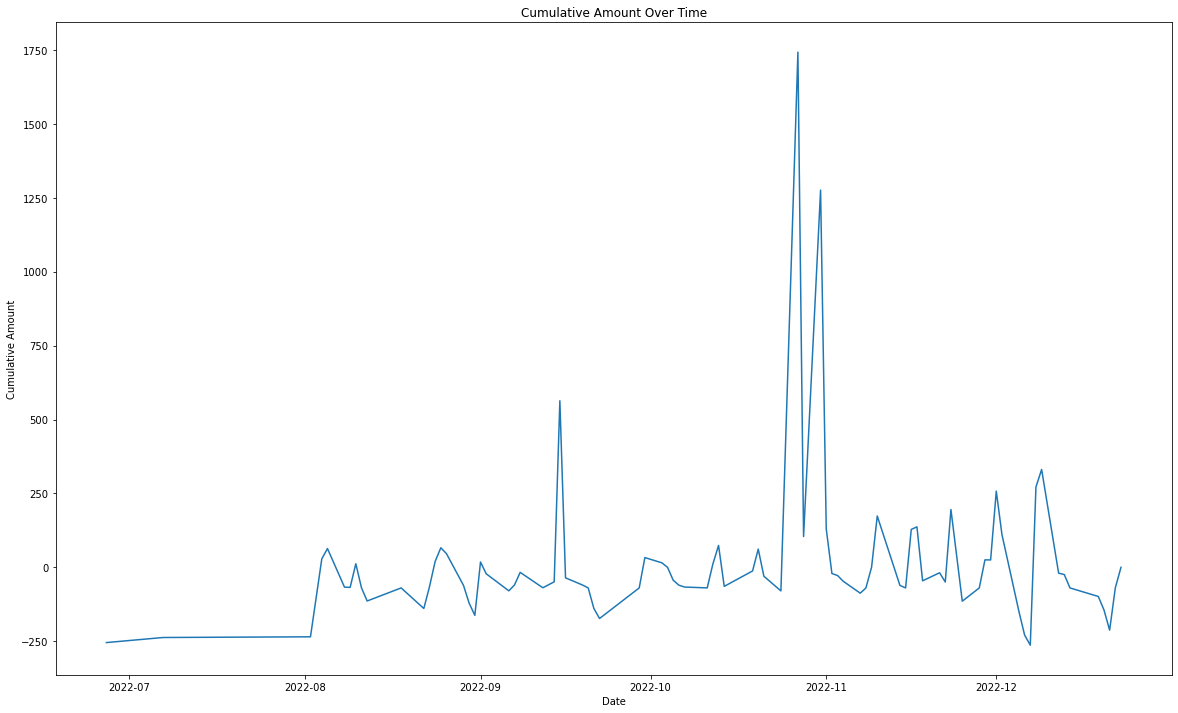

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

d1 = pd.read_parquet('dsc180-fa23/q2_inflows_final.pqt')
d2 = pd.read_parquet('dsc180-fa23/q2_outflows_1sthalf_final.pqt')
d3 = pd.read_parquet('dsc180-fa23/q2_outflows_2ndhalf_final.pqt')

d2['amount'] = -d2['amount']
d3['amount'] = -d3['amount']

merged_table = pd.concat([d1,d2,d3],axis=0, join='outer')

def curve(consumer_id, df):
    data = df[df['prism_consumer_id'] == consumer_id]
    data = data.sort_values('posted_date')
    d = data.groupby(['prism_consumer_id', 'posted_date'], as_index=False).sum(numeric_only=True)
    
    current_balance = acct[acct['prism_consumer_id'] == consumer_id]['balance'].sum()
    print(current_balance)
    d['balance'] = d['amount'].cumsum()
    
    current_balance = acct[acct['prism_consumer_id'] == consumer_id]['balance'].sum()
    d['balance'] = d['balance'] + current_balance - d['balance'].iloc[-1]
    print(d['balance'].iloc[-1])
    plt.figure(figsize=(20, 12))
    plt.plot(d['posted_date'].to_numpy(), d['balance'].to_numpy())
    plt.xlabel('Date')
    plt.ylabel('Cumulative Amount')
    plt.title('Cumulative Amount Over Time')
    plt.show()

curve(2760, merged_table)

In [93]:
acct_on_cons = acct[['prism_consumer_id', 'balance']].groupby('prism_consumer_id').sum()


In [16]:
cons_with_balance = cons.join(acct_on_cons, on='prism_consumer_id')
cons_with_balance.sort_values(by='balance').head(500)

,prism_consumer_id,evaluation_date,APPROVED,FPF_TARGET,balance
122,13,2022-02-14,1,0.0,-7699.94
2380,5750,2022-10-23,1,0.0,-2204.73
2670,4214,2023-01-17,1,1.0,-1852.21
2162,5352,2022-10-04,1,0.0,-1466.21
2455,5772,2022-12-08,1,0.0,-1351.09
...,...,...,...,...,...
1450,2892,2023-02-01,1,0.0,8.08
2303,4418,2022-11-04,1,0.0,8.12
2451,4480,2022-12-28,1,0.0,8.14
1795,2017,2022-11-06,1,1.0,8.20


In [24]:
mod = LogisticRegression()
mod.fit(cons_with_balance[['balance']], cons_with_balance['FPF_TARGET'])

LogisticRegression()

In [77]:
mod.predict(cons_with_balance[['balance']])

array([0., 0., 0., ..., 0., 0., 0.])

In [107]:
def predict(arr):
    res = [1 if x < 100 else 0 for x in arr]
    return res

In [108]:
(predict(cons_with_balance['balance']) == cons_with_balance['FPF_TARGET']).mean()

0.7384150436534587

In [109]:
precision_score(cons_with_balance['FPF_TARGET'], predict(cons_with_balance['balance']))

0.37915742793791574

In [110]:
recall_score(cons_with_balance['FPF_TARGET'], predict(cons_with_balance['balance']))

0.6096256684491979

In [111]:
roc_curve(cons_with_balance['FPF_TARGET'], predict(cons_with_balance['balance']))

(array([0.        , 0.23169218, 1.        ]),
 array([0.        , 0.60962567, 1.        ]),
 array([inf,  1.,  0.]))